In [ ]:
# ✅ FULL RETINANET NOTEBOOK FOR RSOD

# cell 1: Install packages (Linux)
# !pip install torch torchvision albumentations opencv-python matplotlib numpy pandas pycocotools

# cell 2: Paths
import os
train_img_dir = "/content/drive/MyDrive/csv/RSOD_YOLO/train/images"
train_ann_dir = "/content/drive/MyDrive/csv/RSOD_YOLO/train/Annotations"
val_img_dir = "/content/drive/MyDrive/csv/RSOD_YOLO/val/images"
val_ann_dir = "/content/drive/MyDrive/csv/RSOD_YOLO/val/Annotations"

assert os.path.exists(train_img_dir) and os.path.exists(val_img_dir)
print("Paths verified!")

# cell 3: CLAHE transform
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

class CLAHETransform(ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def apply(self, image, **params):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(self.clip_limit, self.tile_grid_size)
        cl = clahe.apply(l)
        merged = cv2.merge((cl,a,b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# cell 4: Transforms
def get_train_transform():
    return A.Compose([
        CLAHETransform(),
        A.RandomBrightnessContrast(0.2,0.2,p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Resize(640, 640),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_val_transform():
    return A.Compose([
        CLAHETransform(),
        A.Resize(640, 640),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# cell 5: Dataset class
import torch
from torch.utils.data import Dataset
from glob import glob
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

class RSODDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.img_files = sorted(glob(os.path.join(img_dir, '*.jpg')) + glob(os.path.join(img_dir, '*.png')))
        self.class_dict = {"aircraft":1, "oiltank":2, "overpass":3, "playground":4}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        xml = os.path.join(self.ann_dir, os.path.basename(img_path).replace(".jpg", ".xml").replace(".png", ".xml"))
        root = ET.parse(xml).getroot()

        boxes, labels = [], []
        for obj in root.findall('object'):
            cls = obj.find('name').text.lower()
            if cls not in self.class_dict: continue
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(self.class_dict[cls])

        boxes = np.array(boxes, dtype=np.float32) if boxes else np.zeros((0,4))
        labels = np.array(labels) if labels else np.zeros(0,)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(transformed['labels'], dtype=torch.int64)

        return image, {'boxes': boxes, 'labels': labels}

train_dataset = RSODDataset(train_img_dir, train_ann_dir, get_train_transform())
val_dataset = RSODDataset(val_img_dir, val_ann_dir, get_val_transform())


# cell 6: RetinaNet model
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

def get_model(num_classes):
    model = retinanet_resnet50_fpn(pretrained=True)
    print(model.head.classification_head)  # Good for debug
    in_feat = model.head.classification_head.conv[0][0].in_channels  # ✅ robust
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(
        in_feat, num_anchors, num_classes
    )
    return model

model = get_model(num_classes=5)



# cell 7: Dataloaders, optimizer, scheduler
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# cell 8: Train + Val loop
import time

def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0
    for imgs, targets in loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.train()  # for loss dict
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(loader)

num_epochs = 20
for epoch in range(num_epochs):
    t0 = time.time()
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | Time: {time.time()-t0:.1f}s")

# cell 9: Save model
torch.save(model.state_dict(), "retinanet_rsod.pth")

# cell 10: COCO mAP eval
import gc
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

torch.cuda.empty_cache()
gc.collect()

model.eval()
results = []
with torch.no_grad():
    for idx, (imgs, targets) in enumerate(val_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)
        for j, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            for k in range(len(boxes)):
                x1,y1,x2,y2 = boxes[k]
                results.append({
                    "image_id": idx,
                    "category_id": int(labels[k]),
                    "bbox": [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                    "score": float(scores[k])
                })

with open("retina_predictions.json", "w") as f:
    json.dump(results, f)

val_image_ids = list(range(len(val_dataset)))
coco_gt = COCO()
dataset = {"info": {}, "licenses": [], "images": [{"id":i} for i in val_image_ids],
           "categories": [{"id":1,"name":"aircraft"},{"id":2,"name":"oiltank"},{"id":3,"name":"overpass"},{"id":4,"name":"playground"}],
           "annotations": []}

ann_id = 0
for img_id in val_image_ids:
    _, target = val_dataset[img_id]
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    for k in range(len(boxes)):
        x1,y1,x2,y2 = boxes[k]
        dataset['annotations'].append({"id":ann_id, "image_id":img_id, "category_id":int(labels[k]),
                                       "bbox":[float(x1),float(y1),float(x2-x1),float(y2-y1)],
                                       "area":float((x2-x1)*(y2-y1)), "iscrowd":0})
        ann_id +=1

coco_gt.dataset = dataset
coco_gt.createIndex()
coco_dt = coco_gt.loadRes("retina_predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

class_names = ["aircraft", "oiltank", "overpass", "playground"]
class_aps = {}
for i, name in enumerate(class_names, 1):
    coco_eval.params.catIds = [i]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_aps[name] = coco_eval.stats[1]
print("\nPer-class AP@0.5:")
for k,v in class_aps.items():
    print(f"{k}: {v:.4f}")


Paths verified!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 171MB/s]


RetinaNetClassificationHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 819, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Epoch 1/20 | Train: 1.4397 | Val: 1.3589 | Time: 203.8s
Epoch 2/20 | Train: 1.1117 | Val: 0.8517 | Time: 157.3s
Epoch 3/20 | Train: 0.7157 | Val: 0.6351 | Time: 156.8s
Epoch 4/20 | Train: 0.5910 | Val: 0.5263 | Time: 156.7s
Epoch 5/20 | Train: 0.4771 | Val: 0.4620 | Time: 15

In [ ]:
# ✅ FINAL COCO mAP EVAL BLOCK FOR RETINANET
import gc
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

torch.cuda.empty_cache()
gc.collect()

# Make sure model is in eval mode and on device
model.eval()
model.to(device)

# 👇 OPTIONAL: lower score threshold for weak boxes
model.score_thresh = 0.01  # if needed

# 👇 Build predictions
results = []
image_ids = []
with torch.no_grad():
    for idx, (imgs, targets) in enumerate(val_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            print(f"Image {idx*len(outputs)+i} — Boxes: {len(boxes)}, Avg Score: {scores.mean() if len(scores) else 0:.4f}")

            for k in range(len(boxes)):
                x1, y1, x2, y2 = boxes[k]
                results.append({
                    "image_id": idx*len(outputs)+i,
                    "category_id": int(labels[k]),
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "score": float(scores[k])
                })
            image_ids.append(idx*len(outputs)+i)

print(f"✅ Total predictions: {len(results)}")

# Save predictions JSON
with open("retina_predictions.json", "w") as f:
    json.dump(results, f)

# 👇 Build COCO GT annotations dict
coco_gt = COCO()
dataset = {
    "info": {}, "licenses": [],
    "images": [{"id": i} for i in range(len(val_dataset))],
    "categories": [
        {"id": 1, "name": "aircraft"},
        {"id": 2, "name": "oiltank"},
        {"id": 3, "name": "overpass"},
        {"id": 4, "name": "playground"}
    ],
    "annotations": []
}

ann_id = 0
for img_id in range(len(val_dataset)):
    _, target = val_dataset[img_id]
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()

    for k in range(len(boxes)):
        x1, y1, x2, y2 = boxes[k]
        dataset['annotations'].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": int(labels[k]),
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "area": float((x2 - x1) * (y2 - y1)),
            "iscrowd": 0
        })
        ann_id += 1

coco_gt.dataset = dataset
coco_gt.createIndex()

# 👇 Run COCO eval
coco_dt = coco_gt.loadRes("retina_predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# ✅ Per-class AP@0.5
class_names = ["aircraft", "oiltank", "overpass", "playground"]
class_aps = {}
for i, name in enumerate(class_names, 1):
    coco_eval.params.catIds = [i]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_aps[name] = coco_eval.stats[1]  # AP@0.5

print("\n✅ Per-class AP@0.5:")
for k, v in class_aps.items():
    print(f"{k}: {v:.4f}")


Image 0 — Boxes: 300, Avg Score: 0.0457
Image 1 — Boxes: 300, Avg Score: 0.0692
Image 2 — Boxes: 300, Avg Score: 0.0402
Image 3 — Boxes: 300, Avg Score: 0.1030
Image 4 — Boxes: 300, Avg Score: 0.0665
Image 5 — Boxes: 300, Avg Score: 0.0375
Image 6 — Boxes: 300, Avg Score: 0.0830
Image 7 — Boxes: 300, Avg Score: 0.1940
Image 8 — Boxes: 300, Avg Score: 0.0914
Image 9 — Boxes: 300, Avg Score: 0.1217
Image 10 — Boxes: 300, Avg Score: 0.0565
Image 11 — Boxes: 300, Avg Score: 0.0779
Image 12 — Boxes: 300, Avg Score: 0.0708
Image 13 — Boxes: 300, Avg Score: 0.1252
Image 14 — Boxes: 300, Avg Score: 0.0495
Image 15 — Boxes: 300, Avg Score: 0.1102
Image 16 — Boxes: 300, Avg Score: 0.0617
Image 17 — Boxes: 300, Avg Score: 0.0668
Image 18 — Boxes: 300, Avg Score: 0.0270
Image 19 — Boxes: 300, Avg Score: 0.1177
Image 20 — Boxes: 300, Avg Score: 0.0470
Image 21 — Boxes: 300, Avg Score: 0.1025
Image 22 — Boxes: 300, Avg Score: 0.0572
Image 23 — Boxes: 300, Avg Score: 0.0445
Image 24 — Boxes: 300, Avg

In [ ]:
import gc
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

torch.cuda.empty_cache()
gc.collect()

# Make sure model is in eval mode and on device
model.eval()
model.to(device)

# 👇 OPTIONAL: lower score threshold for weak boxes
model.score_thresh = 0.01  # if needed

# 👇 Build predictions
results = []
image_ids = []
with torch.no_grad():
    for idx, (imgs, targets) in enumerate(val_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            print(f"Image {idx*len(outputs)+i} — Boxes: {len(boxes)}, Avg Score: {scores.mean() if len(scores) else 0:.4f}")

            for k in range(len(boxes)):
                x1, y1, x2, y2 = boxes[k]
                results.append({
                    "image_id": idx*len(outputs)+i,
                    "category_id": int(labels[k]),
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "score": float(scores[k])
                })
            image_ids.append(idx*len(outputs)+i)

print(f"✅ Total predictions: {len(results)}")

# Save predictions JSON
with open("retina_predictions.json", "w") as f:
    json.dump(results, f)

# 👇 Build COCO GT annotations dict
coco_gt = COCO()
dataset = {
    "info": {}, "licenses": [],
    "images": [{"id": i} for i in range(len(val_dataset))],
    "categories": [
        {"id": 1, "name": "aircraft"},
        {"id": 2, "name": "oiltank"},
        {"id": 3, "name": "overpass"},
        {"id": 4, "name": "playground"}
    ],
    "annotations": []
}

ann_id = 0
for img_id in range(len(val_dataset)):
    _, target = val_dataset[img_id]
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()

    for k in range(len(boxes)):
        x1, y1, x2, y2 = boxes[k]
        dataset['annotations'].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": int(labels[k]),
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "area": float((x2 - x1) * (y2 - y1)),
            "iscrowd": 0
        })
        ann_id += 1

coco_gt.dataset = dataset
coco_gt.createIndex()

# 👇 Run COCO eval
coco_dt = coco_gt.loadRes("retina_predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# ✅ Per-class AP@0.5
class_names = ["aircraft", "oiltank", "overpass", "playground"]
class_aps = {}
for i, name in enumerate(class_names, 1):
    coco_eval.params.catIds = [i]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_aps[name] = coco_eval.stats[1]  # AP@0.5

print("\n✅ Per-class AP@0.5:")
for k, v in class_aps.items():
    print(f"{k}: {v:.4f}")

# ✅ Final total mAP@0.5
total_map_50 = sum(class_aps.values()) / len(class_aps)
print(f"\n✅ FINAL mAP@0.5: {total_map_50:.4f}")


Image 0 — Boxes: 300, Avg Score: 0.0457
Image 1 — Boxes: 300, Avg Score: 0.0692
Image 2 — Boxes: 300, Avg Score: 0.0402
Image 3 — Boxes: 300, Avg Score: 0.1030
Image 4 — Boxes: 300, Avg Score: 0.0665
Image 5 — Boxes: 300, Avg Score: 0.0375
Image 6 — Boxes: 300, Avg Score: 0.0830
Image 7 — Boxes: 300, Avg Score: 0.1940
Image 8 — Boxes: 300, Avg Score: 0.0914
Image 9 — Boxes: 300, Avg Score: 0.1217
Image 10 — Boxes: 300, Avg Score: 0.0565
Image 11 — Boxes: 300, Avg Score: 0.0779
Image 12 — Boxes: 300, Avg Score: 0.0708
Image 13 — Boxes: 300, Avg Score: 0.1252
Image 14 — Boxes: 300, Avg Score: 0.0495
Image 15 — Boxes: 300, Avg Score: 0.1102
Image 16 — Boxes: 300, Avg Score: 0.0617
Image 17 — Boxes: 300, Avg Score: 0.0668
Image 18 — Boxes: 300, Avg Score: 0.0270
Image 19 — Boxes: 300, Avg Score: 0.1177
Image 20 — Boxes: 300, Avg Score: 0.0470
Image 21 — Boxes: 300, Avg Score: 0.1025
Image 22 — Boxes: 300, Avg Score: 0.0572
Image 23 — Boxes: 300, Avg Score: 0.0445
Image 24 — Boxes: 300, Avg

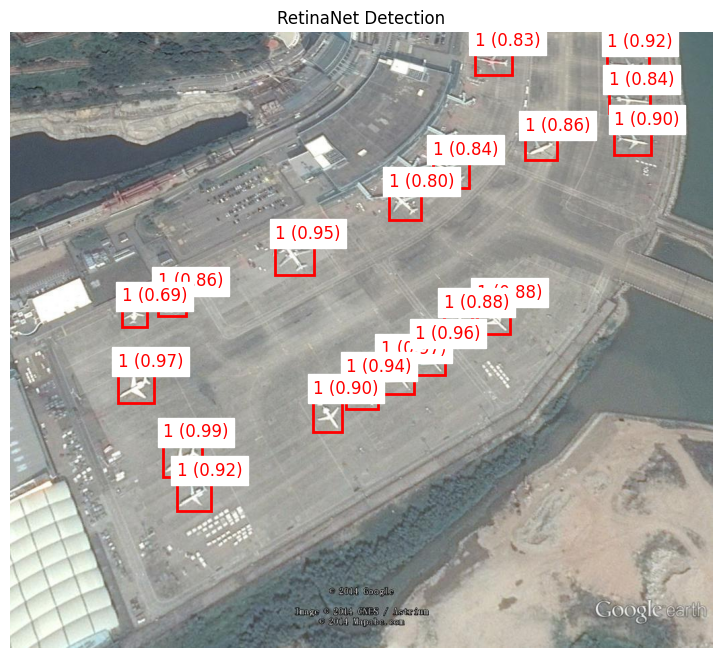

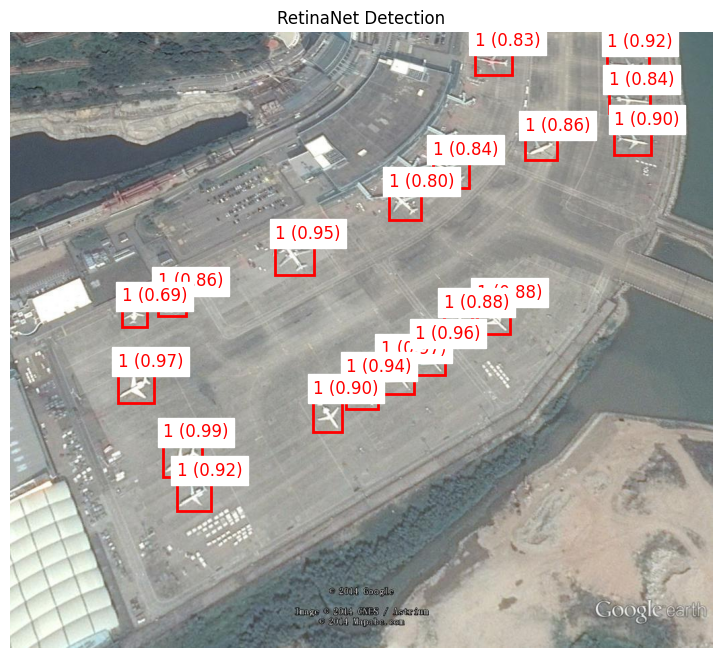

In [7]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 👇 Load image
image_path = "/content/aircraft_8.jpg"  # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


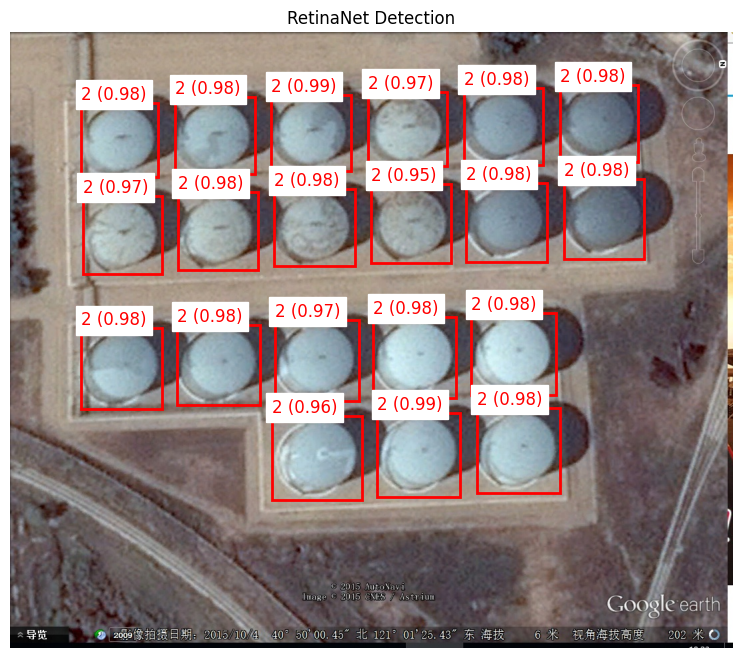

In [8]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 👇 Load image
image_path = "/content/oiltank_9.jpg"  # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


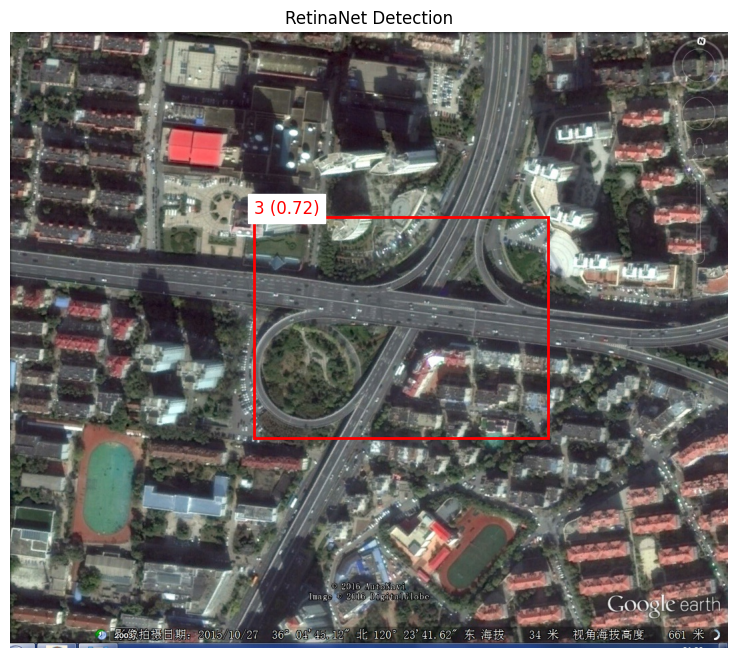

In [12]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 👇 Load image
image_path = "/content/overpass_4.jpg"  # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()


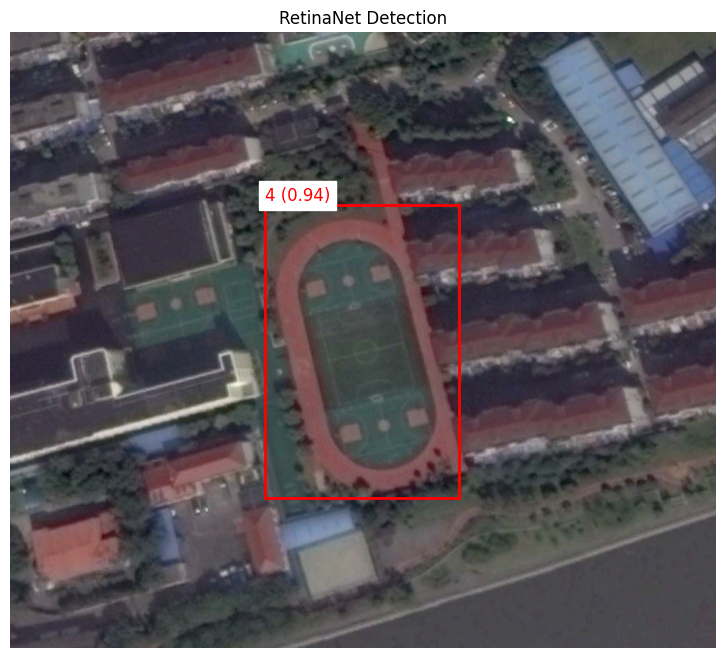

In [14]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 👇 Load image
image_path = "/content/playground_84.jpg"  # 🔄 change this!
img = Image.open(image_path).convert("RGB")

# 👇 Same transform as training
transform = T.Compose([
    T.ToTensor()
])

# 👇 Prepare input tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# 👇 Model to eval
model.eval()
with torch.no_grad():
    output = model(img_tensor)[0]

boxes = output['boxes'].cpu().numpy()
scores = output['scores'].cpu().numpy()
labels = output['labels'].cpu().numpy()

# 👇 Set score threshold for display
score_thresh = 0.5

# ✅ Plot
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, score, label in zip(boxes, scores, labels):
    if score < score_thresh:
        continue
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

plt.title("RetinaNet Detection")
plt.axis('off')
plt.show()
